This notebook will demonstrate the preprocessing step of converting an attribute with continuous data into a discrete attribute using a variety of binning methods (supervised and unsupervised).

Import Dependencies

In [2]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
import re

warnings.filterwarnings('ignore')

Retrieve Data

In [35]:
df = pd.read_csv('../Dataset/preprocessed_data.csv')
df.head()

,Unnamed: 0,alpha,delta,u,g,r,i,z,class,redshift
0,0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123


In [4]:
df.dtypes

obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
class           object
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
dtype: object

Let's pick the attribute "u" to complete discretization on.

In [5]:
u = pd.DataFrame(df.u)
u.head()


,u
0,23.87882
1,24.77759
2,25.26307
3,22.13682
4,19.43718


Let's check for outliers.

In [6]:
print((u < 0).sum())

u    1
dtype: int64


There's an outlier we need to remove.

In [7]:
u.nsmallest(1,'u')


,u
79543,-9999.0


In [8]:
u = u.drop(index=79543)

In [9]:
u.nsmallest(1,'u')

,u
57763,10.99623


Let's look at the data.

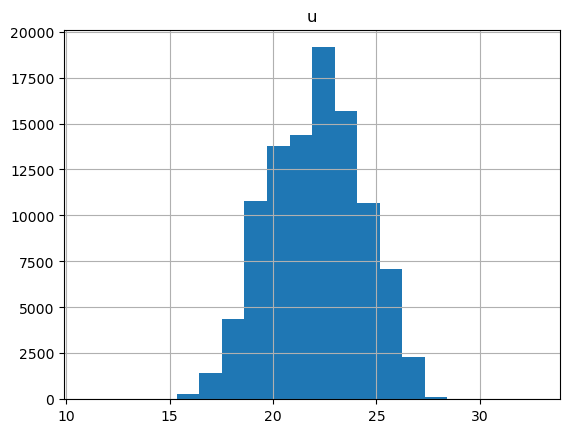

In [10]:
u.hist(bins = 20)
plt.show()

Let's now set up the discretizer so that it uses uniform discretization (bins of same width).

In [11]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

Now let's discretize u.

In [12]:
dc.fit(u)
Xu = dc.transform(u)
print(Xu)

[[5.]
 [6.]
 [6.]
 ...
 [4.]
 [6.]
 [5.]]


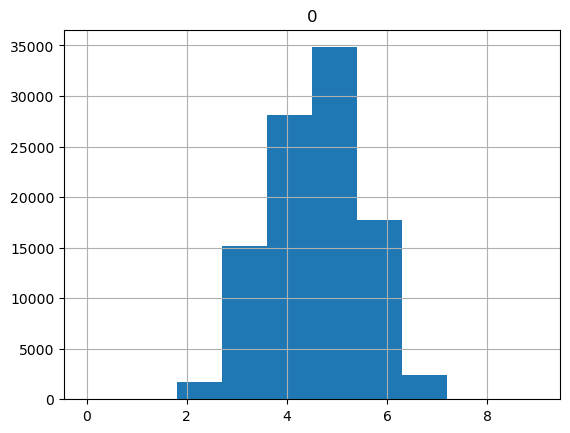

In [13]:
Xd = pd.DataFrame(Xu)
Xd.hist(bins = 10)
plt.show()

In [14]:
print(dc.bin_edges_)

[array([10.99623 , 13.174746, 15.353262, 17.531778, 19.710294, 21.88881 ,
        24.067326, 26.245842, 28.424358, 30.602874, 32.78139 ])          ]


Time to try with quantile binning. Each bin has the same number of values.

In [15]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile');

In [16]:
dc.fit(u)
Xu = dc.transform(u)
print(Xu)

[[7.]
 [8.]
 [9.]
 ...
 [3.]
 [9.]
 [5.]]


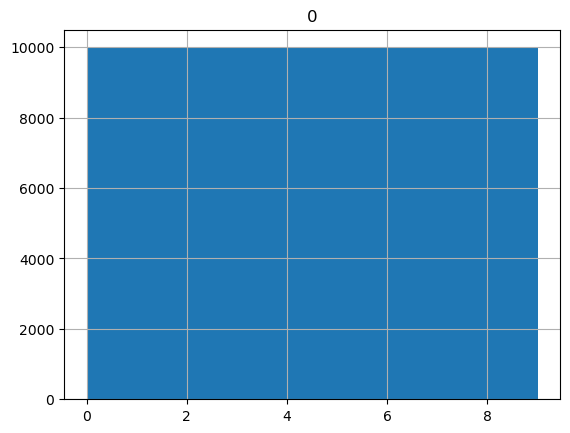

In [17]:
Xd = pd.DataFrame(Xu)
Xd.hist(bins=10)
plt.show()

In [18]:
print(dc.bin_edges_)

[array([10.99623 , 19.117086, 19.961096, 20.74869 , 21.560702, 22.17914 ,
        22.741844, 23.334264, 24.083748, 25.096442, 32.78139 ])          ]


Finally, let's try kmeans.

In [19]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans');

In [20]:
dc.fit(u)
Xu = dc.transform(u).astype(int)
print(Xu)

[[7]
 [8]
 [8]
 ...
 [4]
 [8]
 [5]]


In [21]:
Xu.astype(int).dtype

dtype('int64')

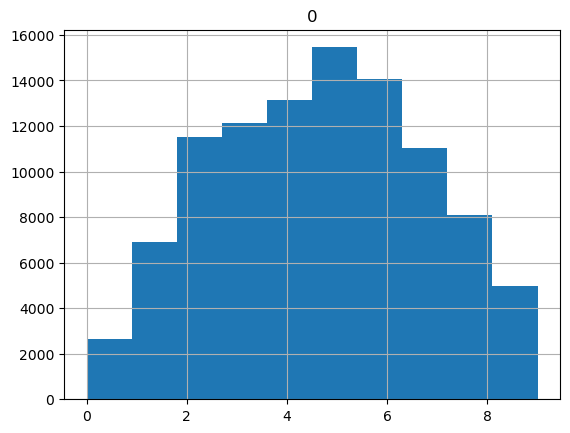

In [22]:
Xd = pd.DataFrame(Xu)
Xd.hist(bins=10)
plt.show()

In [23]:
print(dc.bin_edges_)

[array([10.99623   , 17.86389903, 19.07091461, 20.04854328, 21.02701182,
        21.97193536, 22.84799271, 23.75800982, 24.73827666, 25.79009659,
        32.78139   ])                                                   ]


____
# Part2: K-optimization: 
___

In [24]:
print(df.describe())

             obj_ID          alpha          delta              u  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   1.237665e+18     177.629117      24.135305      21.980468   
std    8.438560e+12      96.502241      19.644665      31.769291   
min    1.237646e+18       0.005528     -18.785328   -9999.000000   
25%    1.237659e+18     127.518222       5.146771      20.352353   
50%    1.237663e+18     180.900700      23.645922      22.179135   
75%    1.237668e+18     233.895005      39.901550      23.687440   
max    1.237681e+18     359.999810      83.000519      32.781390   

                   g              r              i              z  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       20.531387      19.645762      19.084854      18.668810   
std        31.750292       1.854760       1.757895      31.728152   
min     -9999.000000       9.822070       9.469903   -9999.000000   
25%        18.965230      18.135828      1

Each of the above techniques will be assessed on each continuous training variable in order to find the best k-value for each variable per discretization technique. Each technique will have an inherent measure for identifying the best k-value for a given variable. Namely, both equal distance and equal frequency will assess optimal-k through evaluation of the sum of each bin's variance, while k-means discretization will assess the optimal-k through the use of a jump statistic that accounts for the relative difference in distortion within bins from one k-value to the next. Ultimately, these optimal bin numbers per technique will be assessed to establish which technique has the most positive impact on the reduction of correlation across the predictive variables. The approach of establishing discretization techniques through direct competition is established in (reference to credit default paper). The approach here focuses on the change in correlation between variables as the desired outcome for discretization rather than focusing on the information gain in order to avoid the potential for over-fitting that is associated with optimizing to the known outcomes (I think the book identifies that this is a danger with supervised discretization but I am hoping to find another peer reviewed source in case the text is not allowed). In addition, this will prevent the preprocessing steps from impacting the training of the data for a particular modeling technique since it is meant to train multiple models using different modeling algorithms.

#### Equal frequency discretization:
The equal frequency technique will use the sum of within-bin variance for each of k-bins in order to choose the best number of bins. Since each bin's object frequency is the same, there is no need for weighing the impact of each bin to the sum. The goal is to identify what k-value produces that smallest variance. 

#### Equal width discretization:
The equal width technique also utilizes variance as a measure for optimum k-bins but in the context of a weighted sum of bin variances for each k-value candidate. The reason for the weights being that the elements in each bin will vary and variance is inversely proportional to the number of instances that inform on it. Since we are using the lack of cumulative variance to establish likeness of each bin (which ideally is high), the membership size of each bin can lead to false implications for the likeness within each bin and extend those implications to the cumulative measure. Therefore, the cumulative measure for the equal width technique is the weighted sum of bin variance. The scalar of each bin variance is the relative frequency of instances in each bin. This results in the bins with the smallest membership level having the largest reduction in contribution to cumulative variance.

#### K-means Discretization:
The k-means technique for discretization measures optimum k-values as the largest jump between the distortion within each identified cluster. Ideally, the clusters will have the lowest possible amount of distortion because they will only contain instances that are more like the other members than the members of other clusters.The distortion can be established using several different techniques, such as the within-cluster sum of squared distances from each cluster's centroid, but in this case our variable space is one dimensional and doesn't need to account for aspects of multivariates spaces. Therefore, the weighted variance of each clustered bin will achieve the equivalent of jump/gap statistics of multivariate spaces.

Collectively all of the binning methods can be evaluated by the same measure to find the best number of bins.
The following helper function achieves this in each instance regardless of whether or not the bins have consistent or variable bin membership. Specifically for equal membership binning the weight will have a constant value 

In [25]:
def wt_sum_variance(df: pd.DataFrame)->float:
    """
        establishes cumulative variance for binning
        of a variable
    """
    # stores weighted variances of bins
    bin_wt_variances = []
    
    # list of bin number identifiers that are to be iterated through to find the weighted variance of each 
    bins = df.iloc[:,1].unique()

    for bin in bins:
        # get bin members
        bin_members = df[df.iloc[:, 1] == bin].iloc[:, 0]
        # appends bin_wt_variances with next value
        bin_wt_variances.append((bin_members.shape[0]/df.shape[0])*bin_members.var())

    return sum(bin_wt_variances)



(more)... To establish the location of where the elbow exists, the rate at which the change in variance is i closest to zero is observed. This is achieved from estimates of the 1st and second derivative for the discrete plot ok variance against k as the differences between the differences in variance of k values. in order to identify the optimal k- the location just prior to where the second derivative values change signs is identified. 

In [26]:
def best_k_index(variances: list) -> int:
    """
        finds the correct location of the inflection pt 
        in the change in variance
    """
    # second derivative of variance
    acceleration = np.diff(np.diff(variances))
    # starting at one corrects for first indicial shift due to diff array 
    for k in range(1, len(acceleration)): 
        # finds inflection in variance
        if acceleration[k-1] < 0 and acceleration[k] > 0:
            # "+2" addresses second indicial shift
            return k + 2
    return -1  # if no inflection point, return indicator




sandbox cell:

In [27]:
var1 = [32, 20, 8, 2, 1.3, 1.2, 1.1]
best_k_index(var1)

# originally wrote later code in a way where -1 became and index (unintentionally) leading to the last value in the variance list always being returned when an inflection point was not detected. It broke my brain because i couldn't understand where in my code there would be a mechanism that would return the last value in so many instances.

-1

#### K-value candidate range:
The range for candidate k-values tested for each technique is defined to be consistent across all of the binning techniques. The range maximum is determined using the variance and absolute frequency of all instances in the predictive variables. The frequency is inherently constant across variables but the variance is specific to each. The minimum is the number of classes in the predicted variable.

In [36]:
# minimum k candidate range
minK = len(df["class"].unique())

# chunks of k candidates to test: prevents running all potential k's if second deriv of variace reveals inflcation point.
chunk = 10

# predictor df
predict_vars = df.columns[df.dtypes == "float64"]
predict_df = df[predict_vars]
predict_df.drop(list(predict_df.filter(regex = 'ID')), axis = 1, inplace = True)

# predictor variables list
colNames = predict_df.columns

for col in colNames:
    x = predict_df[col]

    # ensures that the 
    maxK = min(int(minK * (len(x)//x.var())), 1000)
    print(f"{col}_maxK: {maxK}")
    k_candidates = np.arange(minK,maxK,1, dtype= int)

    # dictionaries: key = k-value, value = labels
    width_dict = defaultdict(list)
    freq_dict = defaultdict(list)
    kmeans_dict = defaultdict(list)

    # lists: store variances for each bin type
    width_variances = []
    freq_variances = []
    kmeans_variances = []

    for i in range(minK, maxK, chunk):

        # protects from out of bounds at end of loop range
        end_i = min(i+chunk, maxK)   

        for k in range(i, end_i):
            
            # discretizer objects per k
            DC_width = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='uniform') 
        
            # populates the dictionaries
            width_dict[k] = DC_width.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
            
            # creates dfs for variance evaluation
            width_df = pd.DataFrame({'column': x,
                                    'bins': width_dict[k]})

            # populates variance lists
            width_variances.append(wt_sum_variance(width_df))


        best_width_i = best_k_index(width_variances)

        if best_width_i == -1 :
            continue

        best_k_width = k_candidates[best_width_i]
        print(f"{col} width k: {best_k_width}")
        predict_df[f"{col}_width"] = width_dict[best_k_width]

        break

    for i in range(minK, maxK, chunk):

        # protects from outof bounds at end of loop range
        end_i = min(i+chunk, maxK)   

        for k in range(i, end_i):
            
            DC_freq = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='quantile')
        
            # populates the dictionaries
            freq_dict[k] = DC_freq.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()

            # creates dfs for variance evaluation
            freq_df = pd.DataFrame({'column': x,
                                    'bins': freq_dict[k]})
            
            # populates variance lists
            freq_variances.append(wt_sum_variance(freq_df))

        best_freq_i = best_k_index(freq_variances)

        if best_freq_i == -1 :
            continue

        
        best_k_freq = k_candidates[best_freq_i]
        print(f"{col} frequency k: {best_k_freq}")
        predict_df[f"{col}_freq"] = freq_dict[best_k_freq]

        break

    for i in range(minK, maxK, chunk):

        # protects from outof bounds at end of loop range
        end_i = min(i+chunk, maxK)   

        for k in range(i, end_i):
            
            DC_kmeans = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='kmeans')
        
            # populates the dictionaries
            kmeans_dict[k] = DC_kmeans.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()

            # creates dfs for variance evaluation
            kmeans_df = pd.DataFrame({'column': x,
                                    'bins': kmeans_dict[k]})
            
            # populates variance lists
            kmeans_variances.append(wt_sum_variance(kmeans_df))

        best_kmeans_i = best_k_index(kmeans_variances)

        if best_kmeans_i == -1 :
            continue

        
        best_k_kmeans = k_candidates[best_kmeans_i]
        print(f"{col} kmeans k: {best_k_kmeans}")
        predict_df[f"{col}_kmeans"] = kmeans_dict[best_k_kmeans]
        
        break


predict_df.head()


alpha_maxK: 30
alpha width k: 8
alpha frequency k: 12
alpha kmeans k: 10
delta_maxK: 759
delta width k: 8
delta frequency k: 11
delta kmeans k: 10
u_maxK: 1000
u width k: 28
u frequency k: 49
u kmeans k: 16
g_maxK: 1000
g width k: 17
g frequency k: 41
g kmeans k: 19
r_maxK: 1000
r width k: 9
r frequency k: 51
r kmeans k: 20
i_maxK: 1000
i width k: 6
i frequency k: 38
i kmeans k: 17
z_maxK: 1000
z width k: 6
z frequency k: 68
z kmeans k: 14
redshift_maxK: 1000
redshift width k: 18
redshift frequency k: 34
redshift kmeans k: 12


,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,...,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,3,...,11,3,17,8,3,30,6,4,24,4
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,4,...,17,4,33,13,4,65,12,5,27,5
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,4,...,12,3,18,8,3,33,7,4,24,4
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,7,11,...,15,3,29,11,3,39,7,6,28,5
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,7,11,...,3,1,1,2,1,2,1,0,11,1


____
# Part3: Correlation Optimization 
___

In a few instances a optimal number of bins could not be evaluated for a given technique. They include u, g, and z. All of these cases produced an optimal k-value for the frequency binning technique. To accommodate this in the correlation optimization through combinations of the different binning approaches per training variable, descretized variables were produced for those missing by using the same number of bins found for the frequency technique in the other techniques. While this doesn't guarentee that the most optimal combination of binning techniques achivable will be identified, it does allow for there to be a thorough exploration of the effects of binning on correlation in a set of continuous predictors with high correlation. 

In [29]:



DC_width = KBinsDiscretizer(n_bins=54, encode='ordinal', strategy='uniform') 
DC_kmeans = KBinsDiscretizer(n_bins=54, encode='ordinal', strategy='kmeans')


u_width = DC_width.fit_transform(predict_df["u"].values.reshape(-1, 1)).astype(int).flatten()
u_kmeans =  DC_kmeans.fit_transform(predict_df["u"].values.reshape(-1, 1)).astype(int).flatten()

g_width = DC_width.fit_transform(predict_df["g"].values.reshape(-1, 1)).astype(int).flatten()
g_kmeans =  DC_kmeans.fit_transform(predict_df["g"].values.reshape(-1, 1)).astype(int).flatten()

z_width = DC_width.fit_transform(predict_df["i"].values.reshape(-1, 1)).astype(int).flatten()
z_kmeans =  DC_kmeans.fit_transform(predict_df["i"].values.reshape(-1, 1)).astype(int).flatten()

newNames = predict_df.columns
u_freq_idx = next((i for i, s in enumerate(newNames) if re.search("u_freq", s)), None)
print(u_freq_idx)
predict_df.insert(u_freq_idx, "u_width", u_width)
predict_df.insert(u_freq_idx + 2, "u_kmeans", u_kmeans)

newNames = predict_df.columns
g_freq_idx = next((i for i, s in enumerate(newNames) if re.search("g_freq", s)), None)
predict_df.insert(g_freq_idx, "g_width", g_width)
predict_df.insert(g_freq_idx + 2, "g_kmeans", g_kmeans)

newNames = predict_df.columns
z_freq_idx = next((i for i, s in enumerate(newNames) if re.search("z_freq", s)), None)
predict_df.insert(z_freq_idx, "z_width", z_width)
predict_df.insert(z_freq_idx + 2, "z_kmeans", z_kmeans)

14


In [37]:
predict_df.head()

,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,...,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,3,...,11,3,17,8,3,30,6,4,24,4
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,4,...,17,4,33,13,4,65,12,5,27,5
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,4,...,12,3,18,8,3,33,7,4,24,4
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,7,11,...,15,3,29,11,3,39,7,6,28,5
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,7,11,...,3,1,1,2,1,2,1,0,11,1


In [47]:
# separate original continuous predictors from discretized
contPred_df = predict_df.iloc[:,0:8]
discPred_df = predict_df.iloc[:,8:predict_df.shape[1]]

# get correlation matrix for continuous predictors
corr_matrix = contPred_df.corr().values


# print(corr_matrix.shape)

# build name lists based on names of continuous variables s.t. each list has 3 discretized columns corresponding to each continuous name
contVar_names = contPred_df.columns

discVar_names = list(discPred_df.columns)

# assigns appropriate names to distinguishing variables
alpha_names, delta_names, u_names, g_names, r_names, i_names, z_names, redshift_names = [discVar_names[i:i+3] for i in range(0,len(discVar_names),3)]

mosaics_list = []



# iteratively combine binning type var per continuous names with each other s.t there is only one version of binned continuous var in the new df
for a in alpha_names:
    for d in delta_names:
        for u in u_names:
            for g in g_names:
                for r in r_names:
                    for i in i_names:
                        for z in z_names:
                            for red in redshift_names:
                                group_names = [a,d,u,g,r,i,z,red]
                                df = discPred_df[group_names]
                                df_cols = df.columns
                                # print(df.head(3))
                                cor_mat = df.corr().values
                                diffCor_mat = -(corr_matrix - cor_mat)
                                # print(diffCor_mat)
                                summed_corDiff = np.sum(diffCor_mat)
                                # print(cumm_diffCor)
                                obj = {
                                      'variable_names' : df_cols,
                                    #   'df' : df,
                                      'cor_mat' : cor_mat,
                                      'diffCor_mat' : diffCor_mat,
                                      'summed_corDiff' : summed_corDiff
                                    }
                                mosaics_list.append(obj)

                     

  # transform df into cor matrix
  # find and store difference between the continuous corr matrix and the mosaic cor matrix as well as cumulative absolute distance
  # order the mosaic dfs by greatest to least cumulative cor distance

<font style: color = "green"> On the way home I was mulling how the the periodic range of summed correlation differences had much less "amplification" (I am going to keep throwing pseudo-physics in here, at some point I will be comically wrong). I was like oh shit, did the scrubbing of outliers lead to a different corelation matrix, so I checked. It did but not in a way that would make everything else irrelevant, it just calmed the correlation down a bit.

In [48]:
corr_matrix = contPred_df.corr()

corr_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')

,ALPHA,DELTA,U,G,R,I,Z,REDSHIFT
ALPHA,1.000,0.139,-0.000,-0.014,-0.023,-0.024,-0.027,0.000
DELTA,0.139,1.000,-0.026,-0.006,-0.005,-0.003,-0.004,0.047
U,-0.000,-0.026,1.000,0.854,0.727,0.613,0.537,0.151
G,-0.014,-0.006,0.854,1.000,0.936,0.850,0.776,0.358
R,-0.023,-0.005,0.727,0.936,1.000,0.968,0.923,0.483
I,-0.024,-0.003,0.613,0.850,0.968,1.000,0.976,0.540
Z,-0.027,-0.004,0.537,0.776,0.923,0.976,1.000,0.542
REDSHIFT,0.000,0.047,0.151,0.358,0.483,0.540,0.542,1.000


<font style: color = "green"> This was what I was referring to when we met. I thought this was a more complex thing. I actually used it in a copy and past fashion before where I just swapped out the specifics. Its not a comprehension or a generator. Generator was what I was thinking of but I don't think it applies here. I think sometimes lambda is used in that context so I conflated the two contexts. Lambda is just preventing the need to create a user function with a formal definition. 

In [51]:

sorted_mosaics_list = sorted(mosaics_list, key = lambda x: x["summed_corDiff"])

CorChange_max_df = discPred_df[sorted_mosaics_list[len(sorted_mosaics_list)-1]['variable_names']]
CorChange_min_df = discPred_df[sorted_mosaics_list[0]['variable_names']]


In [53]:
print(CorChange_max_df.head())
print(CorChange_min_df.head())

   alpha_width  delta_width  u_kmeans  g_width  r_kmeans  i_kmeans  z_kmeans  \
0            3            4        11       10        11         8         6   
1            3            3        12       11        17        13        12   
2            3            4        13       11        12         8         7   
3            7            1         8       12        15        11         7   
4            7            3         4        4         3         2         1   

   redshift_freq  
0             24  
1             27  
2             24  
3             28  
4             11  
   alpha_freq  delta_kmeans  u_width  g_freq  r_freq  i_width  z_width  \
0           3             5       17      32      29        3        3   
1           4             5       19      36      50        4        4   
2           4             5       20      35      32        3        3   
3          11             1       14      39      44        3        3   
4          11             3        